<a href="https://colab.research.google.com/github/as9786/ParrotnlpJeju/blob/main/toxic/toxic_0331.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd 
import numpy as np 
from google.colab import drive
drive.mount('/content/drive', force_remount=True) 
import tensorflow as tf
import os
import matplotlib.pyplot as plt

os.chdir('/content/drive/MyDrive/parrot/nlp_toxic') 
os.listdir()

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from keras.models import Model
from keras.layers import Dense, Embedding, Input, LSTM, Bidirectional, GlobalMaxPool1D, Dropout, GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential

Mounted at /content/drive


['train.csv',
 'test.csv',
 'sample_submission.csv',
 'test_labels.csv',
 'train_x.npy',
 'train_y.npy',
 'test_x.npy',
 'sub_0328.csv',
 'toxic_0324.ipynb',
 'toxic_0331.ipynb']

### 1. load data

In [ ]:
train = pd.read_csv("./train.csv")
columns = list(train.columns)
columns = columns[2:]
columns

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [ ]:
train.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
train.loc[train["toxic"]==1].head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0


In [ ]:
sample_submission = pd.read_csv("./sample_submission.csv")
sample_submission.head(5)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5


In [ ]:
test = pd.read_csv("./test.csv")
test.head(5)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [ ]:
test_labels = pd.read_csv("./test_labels.csv")
test_labels.head(5)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


### 2. EDA

In [ ]:
train['none'] = (train[columns].max(axis=1) == 0).astype(int)
columns.append('none')
columns

['toxic',
 'severe_toxic',
 'obscene',
 'threat',
 'insult',
 'identity_hate',
 'none']

##### train data type별 수 

In [ ]:
histo = pd.DataFrame(train[columns].sum().sort_values(ascending=False))
histo

,0
none,143346
toxic,15294
obscene,8449
insult,7877
severe_toxic,1595
identity_hate,1405
threat,478


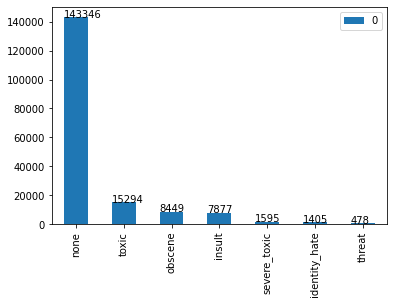

In [ ]:
ax = histo.plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()))

##### train data 문자열 길이 분포

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [ ]:
train_length = train.comment_text.apply(len)
test_length = test.comment_text.apply(len)


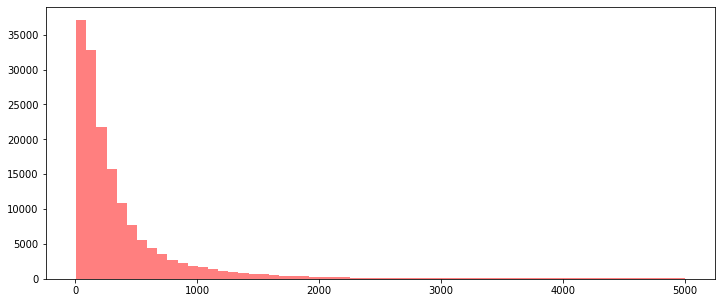

In [ ]:
plt.figure(figsize=(12,5))
plt.hist(train_length, bins=60, alpha=0.5, color='r')
plt.show()

In [ ]:
print("length max : ",np.max(train_length))
print("length min : ", np.min(train_length))
print("mean length : ",np.mean(train_length))
print("75% percentile : ",np.percentile(train_length,75))
print("85% percentile : ",np.percentile(train_length,85))
print("std length : ",np.std(train_length))
below_threshold_len(900, train['comment_text'])

length max :  5000
length min :  6
mean length :  394.0732213246768
75% percentile :  435.0
85% percentile :  663.0
std length :  590.7184309382149
전체 샘플 중 길이가 900 이하인 샘플의 비율: 90.1874400736976


##### test data 문자열 길이 분포

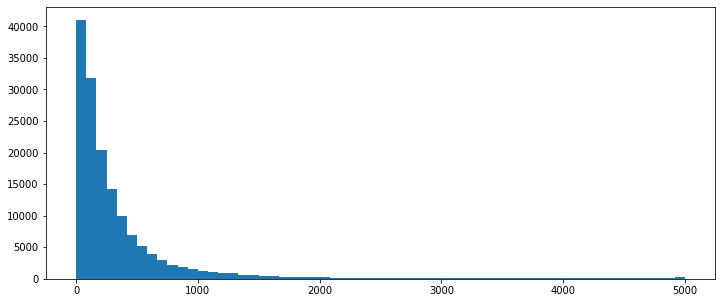

In [ ]:
plt.figure(figsize=(12,5))
plt.hist(test_length, bins=60, )
plt.show()

In [ ]:
print("length max : ",np.max(test_length))
print("length min : ", np.min(test_length))
print("mean length : ",np.mean(test_length))
print("75% percentile : ",np.percentile(test_length,75))
print("85% percentile : ",np.percentile(test_length,85))
print("std length : ",np.std(test_length))
below_threshold_len(900, test['comment_text'])

length max :  5000
length min :  1
mean length :  364.8751207855632
75% percentile :  392.0
85% percentile :  597.0
std length :  592.4901645516898
전체 샘플 중 길이가 900 이하인 샘플의 비율: 91.50518398579301


##### pandas profiling

###### install pandas-profiling

In [ ]:
 pip install -U pandas-profiling

     |████████████████████████████████| 245kB 7.4MB/s 
     |████████████████████████████████| 1.1MB 11.4MB/s 
     |████████████████████████████████| 3.2MB 27.1MB/s 
     |████████████████████████████████| 81kB 11.2MB/s 
     |████████████████████████████████| 61kB 9.2MB/s 
     |████████████████████████████████| 81kB 12.1MB/s 
     |████████████████████████████████| 296kB 48.8MB/s 
  Created wheel for phik: filename=phik-0.11.2-cp37-none-any.whl size=1107413 sha256=559fc8eb7420f006dc6d85cf8613849997e8160b962def44443eb528ce4ffed1
  Stored in directory: /root/.cache/pip/wheels/c0/a3/b0/f27b1cfe32ea131a3715169132ff6d85653789e80e966c3bf6
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp37-none-any.whl size=27085 sha256=249f90da3a4f1b33479ce2ed3086e7b36efcc3b30ecd158c83fd5a3475bf1677
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
Successfully built phik htmlmin
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but

###### ---

In [ ]:
import pandas_profiling
pr=train.profile_report()
pr

Summarize dataset:   0%|          | 0/22 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### 3. 전처리

In [ ]:
X_train = train.comment_text
y_train = train[["toxic",	"severe_toxic",	"obscene",	"threat",	"insult",	"identity_hate"]].values
X_test = test.comment_text

In [ ]:
num_words = 20000
max_len = 150
emb_size = 120

In [ ]:
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(list(X_train))   # fit_on_texts()안에 코퍼스를 입력으로 하면 빈도수를 기준으로 단어 집합을 생성한다.
word_index = tokenizer.word_index
print(list(word_index.items())[:10])


[('the', 1), ('to', 2), ('of', 3), ('and', 4), ('a', 5), ('you', 6), ('i', 7), ('is', 8), ('that', 9), ('in', 10)]


In [ ]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
#데이터 길이 맞춰줌
X_train = sequence.pad_sequences(X_train, maxlen = max_len)
X_test = sequence.pad_sequences(X_test, maxlen=max_len)

In [ ]:
X_train[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,   52, 2635,   13,  555, 3809,   73, 4556, 2706,   21,   94,
         38,  803, 2679,  992,  589, 8377,  182], d

### 4. 모델

##### 1. BiLSTM

In [ ]:
input = Input(shape = (max_len,))
layer = Embedding(num_words,emb_size)(input) #num_words의 단어를 emb_size로 벡터화
layer = Bidirectional(LSTM(50,return_sequences=True,recurrent_dropout=0.15))(layer) #return_sequences : 레이어를 여러 개 쌓아 올릴 때
# recurrent_dropout : 현재 Input에 영향을 받는 Parameter에만 Dropout을 적용하는 것
layer = GlobalMaxPool1D()(layer)
layer = Dropout(0.2)(layer)
layer = Dense(50,activation = 'relu')(layer)
layer = Dropout(0.2)(layer)
layer = Dense(6,activation = 'sigmoid')(layer)
model = Model(inputs = input, outputs=layer)
model.compile(loss = 'binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 150, 128)          2560000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 150, 100)          71600     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0   

In [ ]:
file_path = '{epoch:02d}-{val_loss:.5f}.h5'
checkpoint = ModelCheckpoint(file_path,monitor='val_loss',verbose = 1, save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss',patience=1)

In [ ]:
hist = model.fit(X,y,batch_size=32, epochs=2, validation_split = 0.2, callbacks= [checkpoint,early_stop])

Epoch 1/2
3990/3990 [==============================] - 3271s 819ms/step - loss: 0.1063 - accuracy: 0.7898 - val_loss: 0.0492 - val_accuracy: 0.9941

Epoch 00001: val_loss improved from inf to 0.04923, saving model to 01-0.04923.h5
Epoch 2/2
3990/3990 [==============================] - 3181s 797ms/step - loss: 0.0464 - accuracy: 0.9869 - val_loss: 0.0479 - val_accuracy: 0.9937

Epoch 00002: val_loss improved from 0.04923 to 0.04787, saving model to 02-0.04787.h5


In [ ]:
model.save('toxic1_model1',save_format='tf')

INFO:tensorflow:Assets written to: toxic1_model1/assets


##### 2. GRU

In [ ]:
def bm_gru(num_words, emb):
    input = Input(shape=(max_len,))
    x = Embedding(num_words, emb)(input)
    x = GRU(128)(x)
    x = Dropout(0.2)(x)
    x = Dense(50,activation = 'relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(6,activation = 'sigmoid')(x)

    model = Model(inputs = input, outputs=output)

    model.compile(loss = 'binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
model_gru = bm_gru(num_words, 128)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 128)          26059776  
_________________________________________________________________
gru (GRU)                    (None, 128)               99072     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                6450      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 306   

In [ ]:
hist = model_gru.fit(train_x, train_y, batch_size=32, epochs=5, validation_split = 0.2)

Epoch 1/5
3989/3989 [==============================] - 979s 237ms/step - loss: 0.0899 - accuracy: 0.8826 - val_loss: 0.0470 - val_accuracy: 0.9937
Epoch 2/5
3989/3989 [==============================] - 943s 236ms/step - loss: 0.0388 - accuracy: 0.9874 - val_loss: 0.0466 - val_accuracy: 0.9906
Epoch 3/5
3989/3989 [==============================] - 945s 237ms/step - loss: 0.0293 - accuracy: 0.9378 - val_loss: 0.0516 - val_accuracy: 0.9906
Epoch 4/5
3989/3989 [==============================] - 947s 238ms/step - loss: 0.0221 - accuracy: 0.8954 - val_loss: 0.0642 - val_accuracy: 0.9780
Epoch 5/5
3989/3989 [==============================] - 953s 239ms/step - loss: 0.0164 - accuracy: 0.7391 - val_loss: 0.0795 - val_accuracy: 0.9797


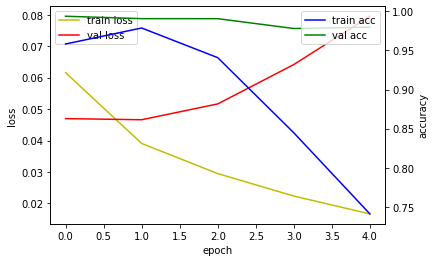

In [ ]:
acc_loss_plot(hist)